# Case Study Unit 10 - Spam Identification
Yao Yao, Brian Kruse, Ivelin Angelov

MSDS 7333 Section 402

July 23, 2018

## Introduction
Procedures for filtering email messages can have misclassify wanted emails as spam and unwanted emails as not spam. 9,348 pre-labeled emails are classified as either ham or spam by SpamAssassin for creating and testing spam filters [1]. Email parts are identified and enumerated into features by header, message body, and attachment. Excessive punctuation, capitalization, number of lines, and number of characters are also identified and enumerated into features. After creating features by message characteristics and tallies, spam filters use decision trees and recursive partitioning to determine message label. Resulting labeled sub-groups split from variable thresholds of certain features are drawn as a tree diagram in the recursive subset partitioning process to train and test the dataset. Classification errors in labeling spam and ham are then evaluated for Type I and Type II errors for multiple models.

We are answering question 20 from the "Data Science in R" textbook (Page 168) [2]: *"We used the test set that we had put aside to both select τ, the threshold for the log odds, and to evaluate the Type I and II errors incurred when we use this threshold. Ideally, we choose τ from another set of messages that is both independent of our training data and our test data. The method of cross-validation is designed to use the training set for training and validating the model. Implement 5-fold cross-validation to choose τ and assess the error rate with our training data.*

## Methods
The steps used for this analysis are: 1) load and clean the data; 2) enumerate data into features by header, message body, and attachment; 3) enumerate data into features by excessive punctuation, capitalization, number of characters, and number of lines; 4) use decision trees and recursive partitioning to determine message label; 5) choose τ to evaluate for Type I and Type II errors for labeling spam and ham; 6) optimize Naive Bayes, CART, random forest, XGBoost, and SVM models by parameter to reduce Type I and II errors by F1 Score [2][3].

In [1]:
options(warn=-1)
suppressPackageStartupMessages(require(tm))
library(RColorBrewer)
library(rpart)
library(rpart.plot)
suppressPackageStartupMessages(require(caret))
suppressPackageStartupMessages(require(MLmetrics))
library(naivebayes)
library(e1071)
suppressPackageStartupMessages(require(randomForest))
library(xgboost)
library(ggplot2)
suppressPackageStartupMessages(require(kernlab))

## Results

### Data Load and Clean

DataLoadAndClean.R is a separate external notebook loaded for the cleaning process and allows us to focus on our analysis for determining message label and evaluate Type I and Type II errors. Exploratory analysis reveals that there are 9348 messages, including 6451 easy ham, 500 hard ham, and 2397 spam messages. The dataset is of dimension 9348 x 30.

In [2]:
# Please use directory with messages downloaded
source('DataLoadAndClean.R', echo = FALSE)

### a) Use the sample() function to permute the indices of the training set, and organize these permuted indices into 5 equal-size sets, called folds.

Using a seed of 418910, the sample function was used to train (67%) and test (33%) the spam and ham datasets. The number of unique words counted in the training set is 80,059.

In [3]:
set.seed(418910)

testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))
testMsgWords = c((msgWordsList[isSpam])[testSpamIdx], (msgWordsList[!isSpam])[testHamIdx] )
trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), c(numSpam - length(testSpamIdx), numHam - length(testHamIdx)))
bow = unique(unlist(trainMsgWords))
length(bow)

spamWordCounts = rep(0, length(bow))
names(spamWordCounts) = bow

tmp = lapply(trainMsgWords[trainIsSpam], unique)
tt = table( unlist(tmp) )
spamWordCounts[ names(tt) ] = tt

[1] 80059

### b) For each fold, take the corresponding subset from the training data to use as a ‘test’ set. Use the remaining messages in the training data as the training set. Apply the functions developed to estimate the probabilities that a word occurs in a message given it is spam or ham, and use these probabilities to compute the log likelihood ratio for the messages in the training set.

The sum of the log likelihood can be calculated by using the bag of words technique by comparing the training set with the test set. The sum of the log likelihood is 255.04 for spam test messages matching with the word bank of the spam training set and the sum of the log likelihood is -124.32 for ham test messages matching with the word bank of the spam training set.

In [4]:
computeFreqs = function(wordsList, spam, bow = unique(unlist(wordsList)))
{
  # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow),
                     dimnames = list(c("spam", "ham", "presentLogOdds", "absentLogOdds"),  bow))
  
  # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5
  
  # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  
  
  # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam
  
  # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
  # log odds
  wordTable["presentLogOdds", ] = log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))
  invisible(wordTable)
}

trainTable = computeFreqs(trainMsgWords, trainIsSpam)
newMsg = testMsgWords[[1]]
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]
present = colnames(trainTable) %in% newMsg
sum(trainTable["presentLogOdds", present]) + sum(trainTable["absentLogOdds", !present])

newMsg = testMsgWords[[ which(!testIsSpam)[1] ]]
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]
present = (colnames(trainTable) %in% newMsg)
sum(trainTable["presentLogOdds", present]) + sum(trainTable["absentLogOdds", !present])

[1] 255.0476

[1] -124.3275

A log likelihood ratio function can be used to find the distribution of words in the ham and spam messages matching with that of the spam word bank [Table 1].

#### Table 1: The Log Likelihood Ratio Distribution For Ham and Spam Messages

In [5]:
computeMsgLLR = function(words, freqTable) 
{
  # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]
  
  # Find which words are present
  present = colnames(freqTable) %in% words
  sum(freqTable["presentLogOdds", present]) + sum(freqTable["absentLogOdds", !present])
}

testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)
tapply(testLLR, testIsSpam, summary)

$`FALSE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1361.89  -127.06  -101.18  -116.25   -81.26   700.23 

$`TRUE`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  -60.574     6.369    49.837   137.546   131.719 23518.028 


#### Table 1: Ham messages have a median of -101.19 and spam messages have a median of 49.837 for their respective log likelihood ratios.

The log likelihood ratio can be displayed using a boxplot for the distribution of both ham and spam messages [Figure 1].

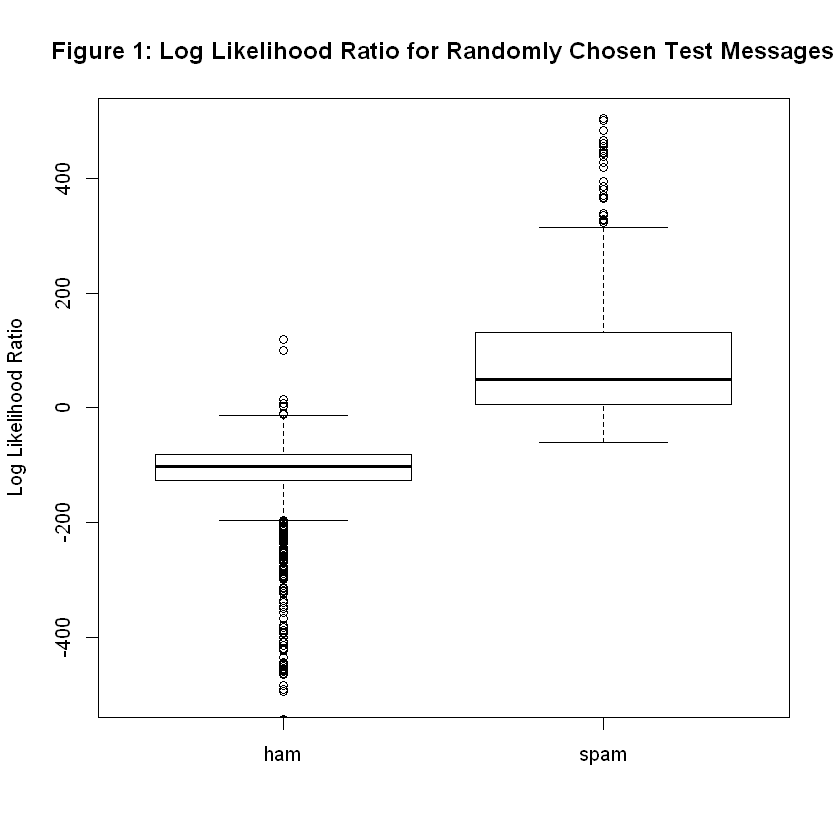

In [6]:
spamLab = c("ham", "spam")[1 + testIsSpam]
boxplot(testLLR ~ spamLab, ylab = "Log Likelihood Ratio",
        main = "Figure 1: Log Likelihood Ratio for Randomly Chosen Test Messages",
        ylim=c(-500, 500))

#### Figure 1: Boxplot showing the distribution of the log likelihood ratios for both spam and ham messages.

### c) Pool all of the likelihood-ratio values from the messages in all of the folds, i.e., from all of the training data, and use these values and the typeIErrorRate() function to select threshold that achieves a 1% Type I error.

The functions typeIErrorRates and typeIIErrorRates uses log likelihood ratios to calculate for false positives and false negatives for all 5 folds, respectively. To minimize the binary classification error for the overall confusion matrix, Tau is introduced to optimize where Type I and Type II errors are at their minimum.

In [7]:
#These functions are for all 5 folds
typeIErrorRates = function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
  
  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

typeIIErrorRates = function(llrVals, isSpam) {
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
  
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
}  

xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
tau01
t1 = max(xI$error[ xI$values > tau01 ])
t1
t2 = max(xII$error[ xII$values < tau01 ])
t2

[1] -43

[1] 0.01035822

[1] 0.02252816

The error rates for spam and ham misclassifications show that Tau is optimized at -43, where the Type I Error rate is minimized at 0.0103 and the Type II Error rate is minimized at 0.0225 [Figure 2].

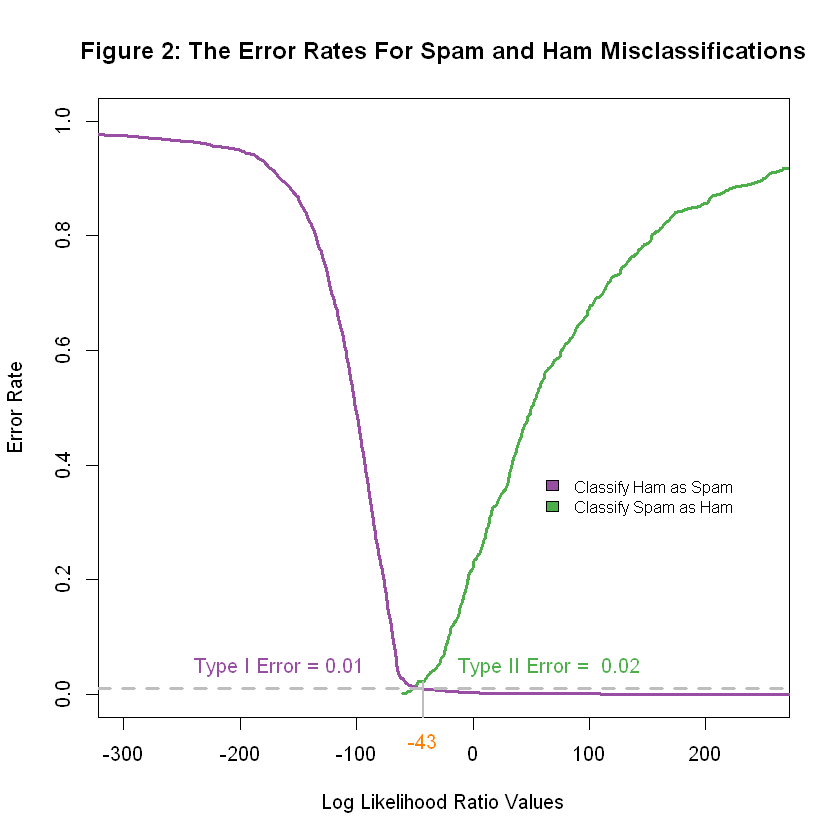

In [8]:
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate",
     main = "Figure 2: The Error Rates For Spam and Ham Misclassifications")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]), 
       legend = c("Classify Ham as Spam", "Classify Spam as Ham"), cex = 0.8, bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4, paste("Type II Error = ", round(t2, digits = 2)), col = cols[1])

#### Figure 2: Tau is optimized at -43 where Type I and Type II errors are at their minimum.

Using five equal folds of the training set, the optimization of Tau and the minimization of Type I and Type II error rates are calculated.

In [9]:
k = 5
numTrain = length(trainMsgWords)
partK = sample(numTrain)
tot = k * floor(numTrain/k)
partK = matrix(partK[1:tot], ncol = k)

testFoldOdds = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  trainTabFold = computeFreqs(trainMsgWords[-foldIdx], trainIsSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, sapply(trainMsgWords[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, trainIsSpam[foldIdx])
}

xFoldI = typeIErrorRates(testFoldOdds, testFoldSpam)
xFoldII = typeIIErrorRates(testFoldOdds, testFoldSpam)
tauFoldI = round(min(xFoldI$values[xFoldI$error <= 0.01]))
tFold2 = xFoldII$error[ xFoldII$values < tauFoldI ]

smallNums = rep((1/2)^40, 2000000)

### Data Feature Creation

DataFeatureCreation.R is another separate external notebook to create additional features from message header, body, and attachment by email parts. It also finds the percentages of capital letters, line and character tallies, spam key words, and excess punctuation. The occurrence of "Re:" in headers and sender's address that end in numbers are evaluated. Spam key words include "viagra", "pounds", "free", "weight", "guarantee", "million", "dollars", "credit", "risk", "prescription", "generic", "drug", "financial", "save", "erotic", "barrister", "beneficiary", "easy", "money back", "money", and "credit card".

In [10]:
# Another cleaning file to distinguish message header, body, and attachment by email parts
# Find percentage of capital letters, character frequencies, word tallies, spam key words, and excess punctuation
source('DataFeatureCreation.R', echo = FALSE)

[1] 1.8189894035458565e-06
[1] 10000.000001818989
[1] 10000


The number of lines and the number of characters within message bodies are positively correlated [Figure 3].

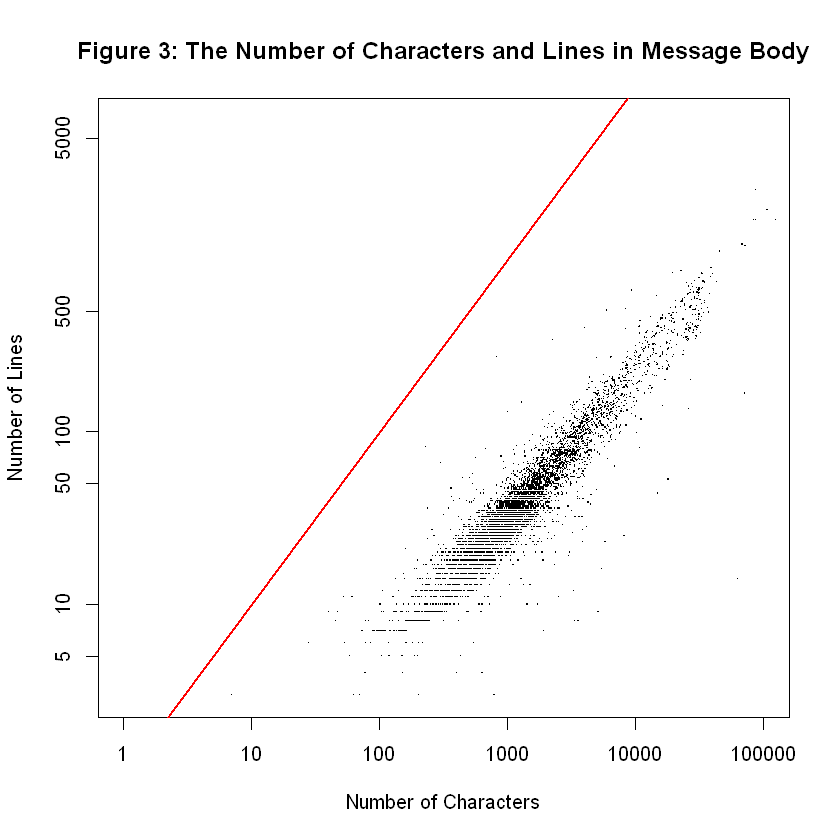

In [11]:
plot(nL ~ nC, log = "xy", pch=".", xlim=c(1,100000), axes = FALSE, 
     xlab = "Number of Characters", ylab = "Number of Lines", main = "Figure 3: The Number of Characters and Lines in Message Body")
box() 
axis(1, at = x.at, labels = formatC(x.at, digits = 0, format="d"))
axis(2, at = y.at, labels = formatC(y.at, digits = 0, format="d")) 
abline(a=0, b=1, col="red", lwd = 2)

#### Figure 3: The number of lines and the number of characters are positively correlated

Spam messages have a slightly higher percentage of capital letters than ham messages [Figure 4].

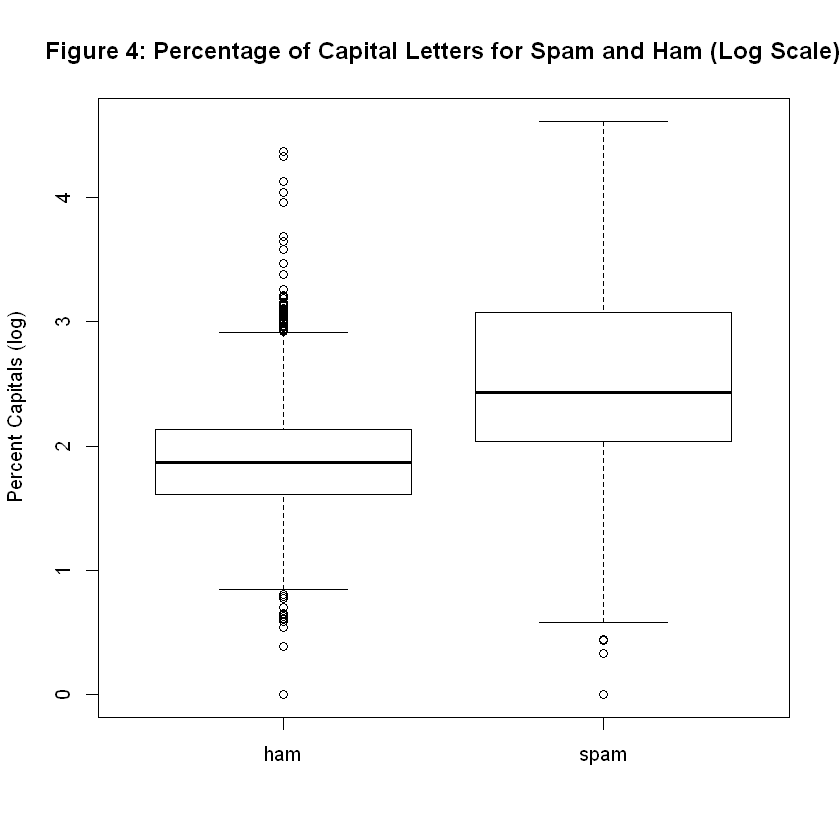

In [12]:
percent = emailDF$perCaps
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs, ylab = "Percent Capitals (log)", 
        main = "Figure 4: Percentage of Capital Letters for Spam and Ham (Log Scale)")

#### Figure 4: Spam messages tend to have more capital letters than ham messages.

The percentage of capital letters of spam and ham emails when graphed against each other show that spam messages have a higher tendancy of capital letters than ham messages [Figure 5].

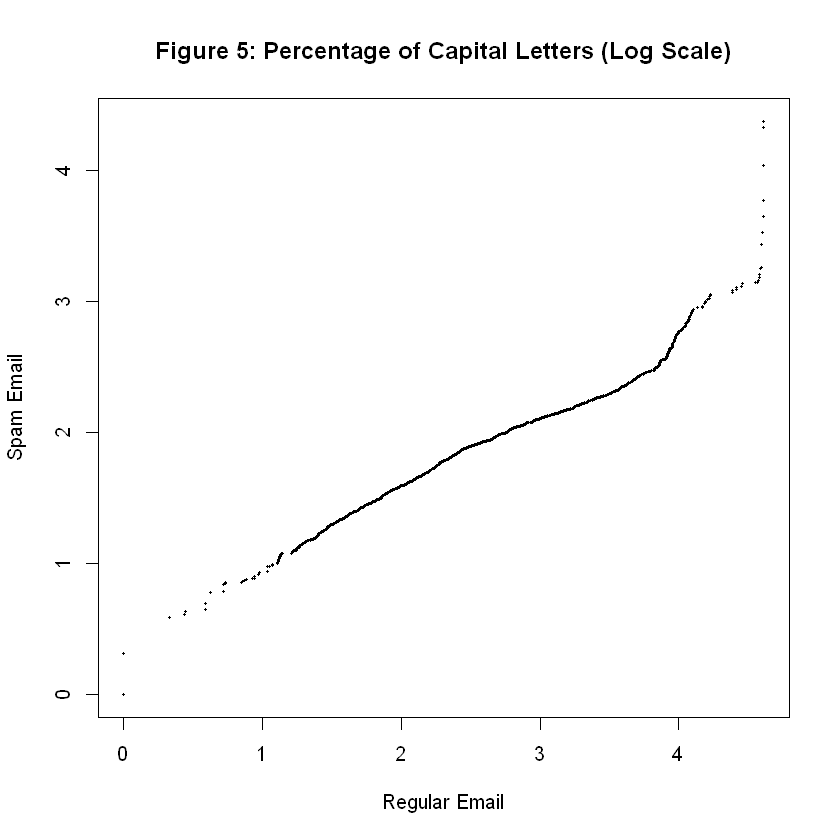

In [13]:
logPerCapsSpam = log(1 + emailDF$perCaps[ emailDF$isSpam ])
logPerCapsHam = log(1 + emailDF$perCaps[ !emailDF$isSpam ])

qqplot(logPerCapsSpam, logPerCapsHam, 
       xlab = "Regular Email", ylab = "Spam Email", 
       main = "Figure 5: Percentage of Capital Letters (Log Scale)",
       pch = 19, cex = 0.3)

#### Figure 5: Spam messages have a higher tendancy of capital letters than ham messages.

A scatterplot shows that spam messages tend to have more capital letters and total characters than ham messages [Figure 6].

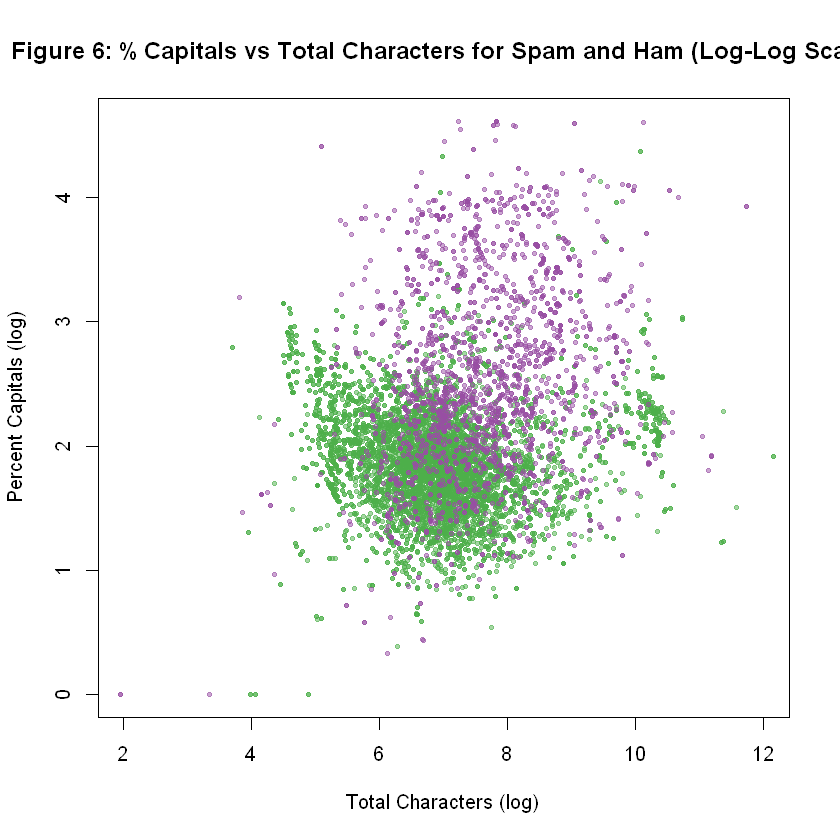

In [33]:
colI = c("#4DAF4A80", "#984EA380")
logBodyCharCt = log(1 + emailDF$bodyCharCt)
logPerCaps = log(1 + emailDF$perCaps)
plot(logPerCaps ~ logBodyCharCt, xlab = "Total Characters (log)",
     ylab = "Percent Capitals (log)", main = "Figure 6: % Capitals vs Total Characters for Spam and Ham (Log-Log Scale)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,12), pch = 19, cex = 0.5)

#### Figure 6: Spam messages (purple) tend to have more capital letters and total characters than ham messages (green) [Figure 6].

Number of attachments does not clearly indicate whether a message is spam or ham [Table 2].

#### Table 2: Number of Attachments for Spam and Ham Messages

In [15]:
table(emailDF$numAtt, isSpamLabs)
oldPar = par(mfrow = c(1, 2), mar = c(1,1,1,1))

    isSpamLabs
      ham spam
  0  6624 2158
  1   314  230
  2    11    6
  4     0    1
  5     1    2
  18    1    0

#### Table 2: Number of attachments does not clearly indicate whether a message is spam or ham

Ham messages tend to have more replies in the headers than spam messages [Figure 7]. 

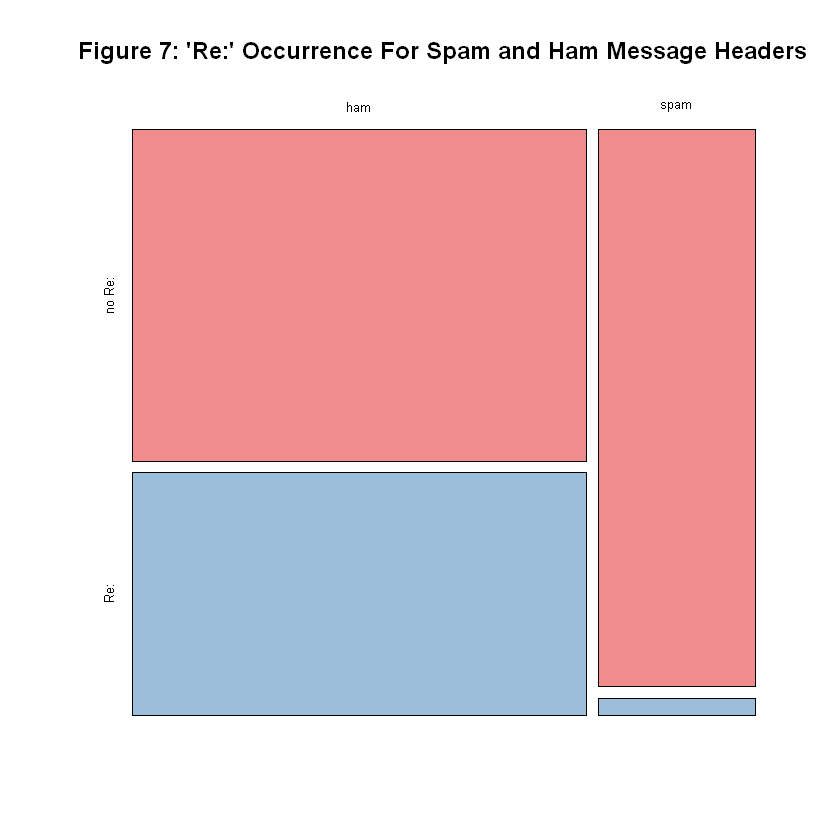

In [16]:
colM = c("#E41A1C80", "#377EB880")
isRe = factor(emailDF$isRe, labels = c("no Re:", "Re:"))
mosaicplot(table(isSpamLabs, isRe), main = "Figure 7: 'Re:' Occurrence For Spam and Ham Message Headers", xlab = "", ylab = "", color = colM)

#### Figure 7: 'Re:' in message headers occurs more for ham than spam messages

Spam messages tend to have more numeric ends for senders' addresses than ham messages [Figure 8].

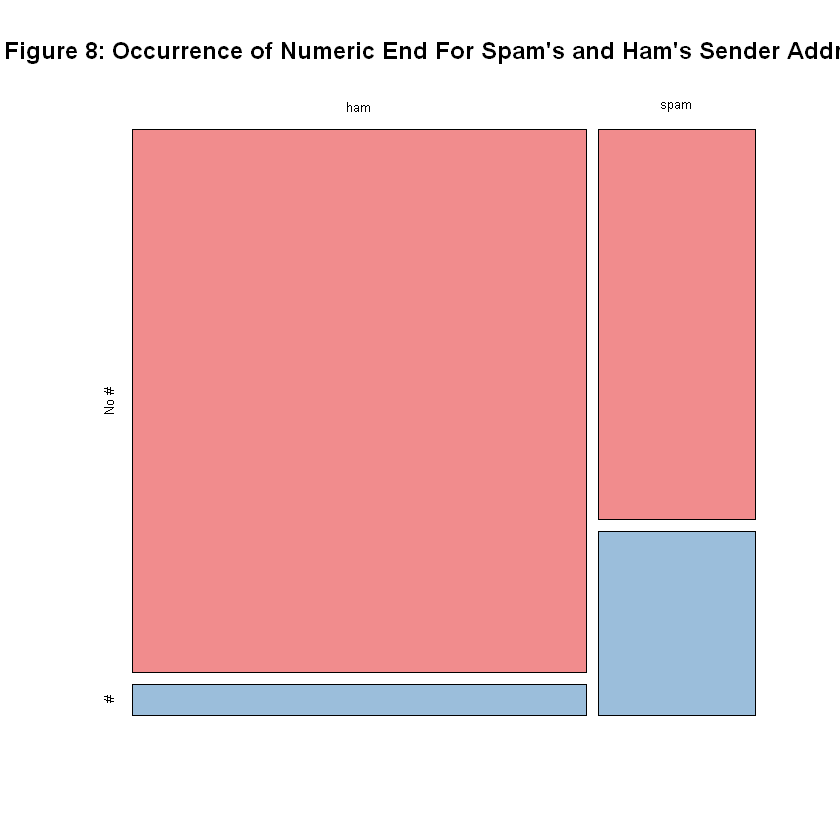

In [17]:
fromNE = factor(emailDF$numEnd, labels = c("No #", "#"))
mosaicplot(table(isSpamLabs, fromNE), color = colM, 
           main = "Figure 8: Occurrence of Numeric End For Spam's and Ham's Sender Address", xlab="", ylab = "")

#### Figure 8: Sender's address tend to have a numeric end for spam messages than ham messages

A decision tree with recursive partitioning based on the features created determines message label for ham or spam [Figure 9]. Features created include percent of capital letters, characters in body, HTML, forwarded email, replied email, numeric end of sender address, number of attachments, has dear, all caps, blank subject, subject exclamation count, and multiple paragraphs.

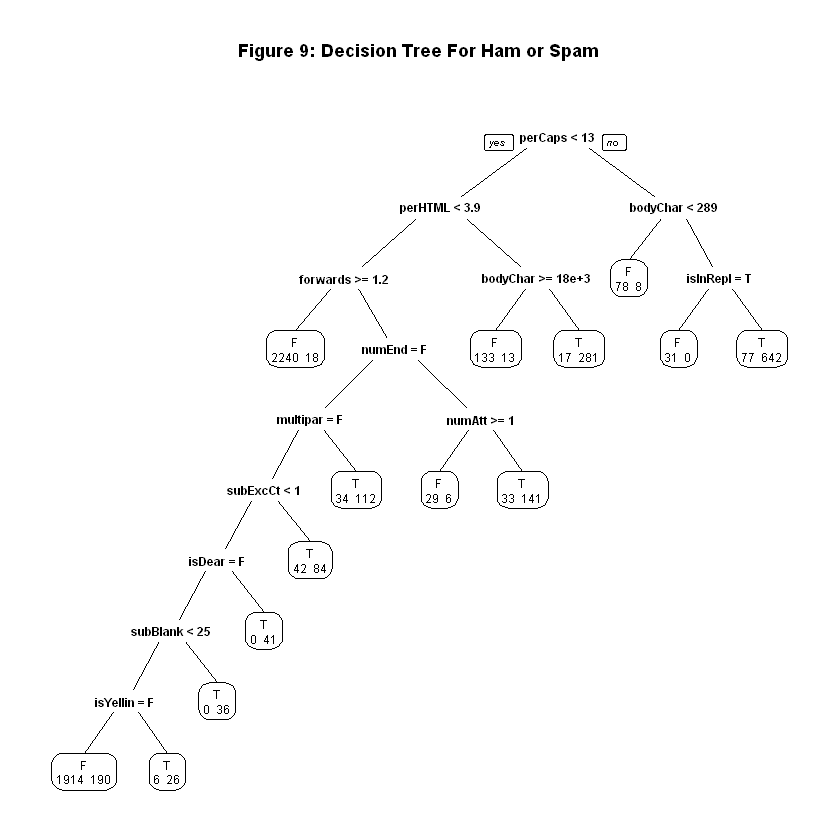

In [18]:
setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)

set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ], 
               emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF = rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
                emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")
prp(rpartFit, extra = 1, main ="Figure 9: Decision Tree For Ham or Spam")

#### Figure 9: A decision tree with recursive partitioning based on the features created determines message label for ham or spam.

The decision tree predictions for ham messages has 2192 true positives and 125 false negatives [Table 3].

#### Table 3: Summary for Ham Predictions

In [19]:
predictions = predict(rpartFit, newdata = testDF[, names(testDF) != "isSpam"], type = "class")
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

F    T 
2192  125

#### Table 3: The decision tree predictions for ham messages has 2192 true positives and 125 false negatives

The classifier has a 5.39% for Type I errors and a 15.6% for Type II errors.

In [20]:
sum(predsForHam == "T") / length(predsForHam)
predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

[1] 0.05394907

[1] 0.1564456

### d) Apply this threshold to our original/real test set and find its Type I and Type II errors.

Optimizing the value for complexity parameter, the best cp value is at 0.001, where Type I Error is minimal at 3.8% and Type II Error is minimal at 12.6% [Figure 10]. 

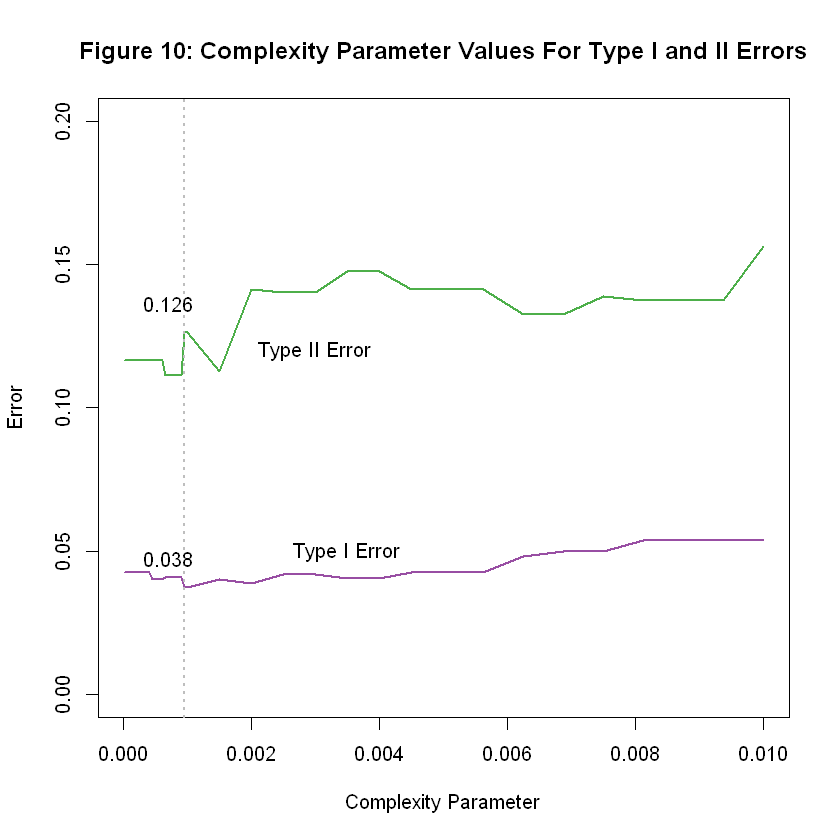

In [21]:
fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF, method="class", control = rpart.control(cp=x) )
         predict(rpartObj, newdata = testDF[ , names(testDF) != "isSpam"], type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.01), 
     ylab="Error", xlab="Complexity Parameter", main = "Figure 10: Complexity Parameter Values For Type I and II Errors")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)
text(x =c(0.003, 0.0035), y = c(0.12, 0.05), labels=c("Type II Error", "Type I Error"))
minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)
text(0.0007, errs[1, minI]+0.01, formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, formatC(errs[2, minI], digits = 3))

#### Figure 10: The optimal cp value is at 0.001, where Type I Error is 3.8% and Type II Error is 12.6%

The function setupRnum changes true and false into numbers for further analysis. Missing values are turned into zero.

In [22]:
setupRnum = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], function(x) {x = as.numeric(x)})
  cbind(facVars, data[ , - logicalVars])
}

emailDFnum = setupRnum(emailDF)
emailDFnum[is.na(emailDFnum)]<-0

A list of a fixed set of folds is created by a seed value for 7478 and 7479 observations.

In [23]:
cv_folds <- createFolds(emailDFnum$isSpam, k=5, list=TRUE, returnTrain = TRUE)
lengths(cv_folds)

Fold1 Fold2 Fold3 Fold4 Fold5 
 7478  7478  7479  7479  7478

The F1 Score, which is the harmonic mean between precision and recall, is used to minimize both Type I and Type II Errors for the rest of the analysis. The precision is how many classified spam is actually spam and the recall is how much actual spam are classified as spam. The models for Naive Bayes, CART, random forest, XGBoost, and SVM can be optimized by parameter using the Caret package documentation [4].

In [24]:
f1 <- function(data, lev = NULL, model = NULL) {
  f1_val <- F1_Score(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  p <- Precision(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  r <- Recall(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  fp <-sum(data$pred==1 & data$obs==0)
  fn <-sum(data$pred==0 & data$obs==1)
  tn <-sum(data$pred==0 & data$obs==0)
  tp <-sum(data$pred==1 & data$obs==1)
    t1e<-fp/(fp+tn)
    t2e<-fn/(fn+tp)
    c(F1 = f1_val, prec = p, rec = r, Type_I_err=t1e, Type_II_err=t2e)
}

A Naive Bayes classifier with a bag-of-words framework is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The Naive Bayes model is optimized using a tuning grid, which permutates through laplace values of 0, 0.1, 0.3, 0.5, and 1, usekernel of True and False, and adjust values and True and False [Table 4]. The optimal Naive Bayes model by an F1 Score of 91.21% is where laplace = 0, usekernel = False, and adjust = False for Type I Error to be 10.99% and Type II Error to be 17.52% [Table 4].

#### Table 4: The Naive Bayes model permutates through laplace, usekernel, and adjust value parameters.

In [25]:
nb_grid<-expand.grid(laplace=c(0,0.1,0.3,0.5,1), usekernel=c(T,F), adjust=c(T,F))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_nb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, 
                       method='naive_bayes',tuneGrid = nb_grid)
model_nb

Naive Bayes 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  F1         prec       rec        Type_I_err 
  0.0      FALSE      FALSE   0.9121106  0.9379491  0.8900878  0.109912243
  0.0      FALSE       TRUE   0.9121106  0.9379491  0.8900878  0.109912243
  0.0       TRUE      FALSE   0.8921701  0.8073419  0.9974104  0.002589555
  0.0       TRUE       TRUE   0.8921701  0.8073419  0.9974104  0.002589555
  0.1      FALSE      FALSE   0.9121106  0.9379491  0.8900878  0.109912243
  0.1      FALSE       TRUE   0.9121106  0.9379491  0.8900878  0.109912243
  0.1       TRUE      FALSE   0.8921701  0.8073419  0.9974104  0.002589555
  0.1       TRUE       TRUE   0.8921701  0.8073419  0.9974104  0.002589555
  0.3      FALSE      FALSE   0.9121106  0.9379491  0.8900878  0.109912243
  0.3      FALSE       TRUE   0.912110

#### Table 4: The optimal Naive Bayes model by an F1 Score of 91.21% is where laplace = 0, usekernel = False, and adjust = False.

Table 5 shows that the prediction folds have equal number of observations [Table 5].

#### Table 5: Equal Number of Prediction Folds

In [26]:
table(model_nb$pred['Resample'])


Fold1 Fold2 Fold3 
 3116  3116  3116 

#### Table 5: Prediction Folds Show 3116 For Each Fold

A CART classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 5 folds. The CART model is optimized using a tuning grid, which permutates through Complexity Parameter values from 0 to 0.01 by a step value of 0.0005 [Table 6]. The optimal CART model by an F1 Score of 95.81% is where cp = 0.001 for Type I Error to be 3.98% and Type II Error to be 12.76% [Table 6].

#### Table 6: The CART model permutates through Complexity Parameter values.

In [27]:
val<-seq(from = 0, to=0.01, by=0.0005)
cart_grid<-expand.grid(cp=val)
train_control<-trainControl(method="cv", number =5, savePredictions = 'final',summaryFunction = f1)
model_rpart<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, 
                          method='rpart',tuneGrid = cart_grid)
model_rpart

CART 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7478, 7478, 7478, 7479, 7479 
Resampling results across tuning parameters:

  cp      F1         prec       rec        Type_I_err  Type_II_err
  0.0000  0.9581525  0.9561686  0.9601489  0.03985115  0.1276574  
  0.0005  0.9590785  0.9557457  0.9624508  0.03754920  0.1293267  
  0.0010  0.9612105  0.9581377  0.9643216  0.03567838  0.1222330  
  0.0015  0.9593084  0.9572004  0.9614442  0.03855577  0.1247364  
  0.0020  0.9581564  0.9592122  0.9571287  0.04287128  0.1180637  
  0.0025  0.9575135  0.9553423  0.9597183  0.04028167  0.1301644  
  0.0030  0.9570396  0.9544202  0.9597189  0.04028115  0.1330880  
  0.0035  0.9556337  0.9538952  0.9574167  0.04258331  0.1343406  
  0.0040  0.9546036  0.9548451  0.9543958  0.04560417  0.1310073  
  0.0045  0.9534228  0.9542049  0.9526695  0.04733047  0.1326731  
  0.0050  0.9518631  0.9533941  0.9503674  0.0

#### Table 6: The optimal CART model by an F1 Score of 95.81% is where cp = 0.001

A Random Forest classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The random forest model is optimized using a tuning grid, which permutates through mtry, which is the number of predictors sampled for splitting at each node, valued from 1 to 25 by a step value of 2 [Table 7]. The optimal Random Forest model by an F1 Score of 98.48% is where mtry = 7 for Type I Error to be 1.16% and Type II Error to be 5.42% [Table 7].

#### Table 7: The Random Forest Model permutates through mtry values

In [28]:
rf_grid<-expand.grid(mtry=seq(from =1, to = 25, by = 2))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_rf<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control, 
                       ntree=200,method='rf',tuneGrid = rf_grid)
model_rf

Random Forest 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  mtry  F1         prec       rec        Type_I_err   Type_II_err
   1    0.9153283  0.8469185  0.9958279  0.004172062  0.52231957 
   3    0.9768549  0.9702029  0.9835995  0.016400518  0.08760951 
   5    0.9841708  0.9800324  0.9883470  0.011653000  0.05840634 
   7    0.9848776  0.9814355  0.9883470  0.011653000  0.05423446 
   9    0.9847333  0.9812889  0.9882031  0.011796864  0.05465165 
  11    0.9839442  0.9805747  0.9873400  0.012660049  0.05673759 
  13    0.9840776  0.9812636  0.9869084  0.013091641  0.05465165 
  15    0.9842223  0.9814126  0.9870522  0.012947777  0.05423446 
  17    0.9836502  0.9806988  0.9866206  0.013379370  0.05632040 
  19    0.9837958  0.9807048  0.9869084  0.013091641  0.05632040 
  21    0.9828736  0.9791555  0.9866206  0.013379370  0.0609

#### Table 7: The optimal Random Forest model by an F1 Score of 98.48 is where mtry = 7

An eXtreme Gradient Boost (XGBoost) classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The XGBoost model is optimized using a tuning grid, which permutates through a max depth value of 3, 5, 7, 9, and 11, an eta value of 0.01, 0.03, and 0.1, and a gamma value of 1, 3, 5, and 10 [Table 8]. Other parameters of XGBoost include number of rounds = 100, columns sampled by tree = 1, minimum child weight = 1, and subsample = 1. The optimal XGBoost model by an F1 Score of 96.99% is where max depth = 11, eta = 0.1, and gamma = 1 for Type I Error to be 1.33% and Type II Error to be 7.17% [Table 8].

#### Table 8: The XGBoost model permutates through Max Depth, Eta, and gamma values.

In [29]:
xgb_grid<-expand.grid(nrounds = 100, max_depth = c(3,5,7,9,11), eta = c(0.01,0.03,0.1), 
                      gamma=c(1,3,5,10), colsample_bytree=1, min_child_weight=1, subsample=1)
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_xgb<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,
                        method='xgbTree',tuneGrid = xgb_grid)
model_xgb

eXtreme Gradient Boosting 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  eta   max_depth  gamma  F1         prec       rec        Type_I_err
  0.01   3          1     0.9325138  0.8910818  0.9779888  0.02201122
  0.01   3          3     0.9320846  0.8908973  0.9772695  0.02273054
  0.01   3          5     0.9321577  0.8909110  0.9774133  0.02258668
  0.01   3         10     0.9319668  0.8905632  0.9774133  0.02258668
  0.01   5          1     0.9507558  0.9253922  0.9775572  0.02244281
  0.01   5          3     0.9509613  0.9256514  0.9777011  0.02229895
  0.01   5          5     0.9512952  0.9262849  0.9777011  0.02229895
  0.01   5         10     0.9511802  0.9269723  0.9766940  0.02330600
  0.01   7          1     0.9591569  0.9425066  0.9764063  0.02359373
  0.01   7          3     0.9592800  0.9430139  0.9761185  0.02388146
  0.

#### Table 8: The optimal Random Forest model by an F1 Score of 98.48 is where mtry = 7

A Support Vector Machine with Linear Kernel classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The Linear SVM model is optimized using a tuning grid, which permutates through a cost value of 0.001, 0.01, 0.1, 1, 10, and 100 [Table 9]. The optimal Linear SVM model by an F1 Score of 94.54% is where cost = 10 for Type I Error to be 3.33% and Type II Error to be 22.69% [Table 9].

#### Table 9: The Linear SVM model permutates through cost values.

In [30]:
svm_grid<-expand.grid(cost=c(0.001,0.01,0.1,1,10,100))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_svm<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='svmLinear2',tuneGrid = svm_grid)
model_svm

Support Vector Machines with Linear Kernel 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  cost   F1         prec       rec        Type_I_err  Type_II_err
  1e-03  0.9327343  0.9012696  0.9664796  0.03352036  0.3070505  
  1e-02  0.9420311  0.9186760  0.9666235  0.03337649  0.2482270  
  1e-01  0.9432474  0.9226816  0.9647533  0.03524673  0.2344597  
  1e+00  0.9450248  0.9241094  0.9669112  0.03308876  0.2302879  
  1e+01  0.9454100  0.9251133  0.9666235  0.03337649  0.2269504  
  1e+02  0.9451192  0.9249523  0.9661919  0.03380809  0.2273675  

F1 was used to select the optimal model using the largest value.
The final value used for the model was cost = 10.

#### Table 9: The optimal Linear SVM model by an F1 Score of 94.54% is where cost = 10

A Support Vector Machine with Polynomial Kernel classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The Polynomial SVM model is optimized using a tuning grid, which permutates through a C value of 0.001, 0.01, 0.1, 1, 10, and 100, and a degree value of 1, 2, and 3 [Table 10]. Other parameters for Polynomial SVM includes scale to be True. The optimal Polynomial SVM model by an F1 Score of 96.94% is where degree = 2 and C = 1 for Type I Error to be 2.24% and Type II Error to be 11.38% [Table 10].

#### Table 10: The Polynomial SVM model permutates through C and degree values.

In [31]:
svm_grid<-expand.grid(C=c(0.001,0.01,0.1,1,10,100),scale=TRUE,degree=c(1,2,3))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_svm<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='svmPoly',tuneGrid = svm_grid)
model_svm

Support Vector Machines with Polynomial Kernel 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  C      degree  F1         prec       rec        Type_I_err  Type_II_err
  1e-03  1       0.9310998  0.8992480  0.9653287  0.03467127  0.3137255  
  1e-03  2       0.9595120  0.9416303  0.9781326  0.02186736  0.1760534  
  1e-03  3       0.9669600  0.9514197  0.9830240  0.01697597  0.1455987  
  1e-02  1       0.9414085  0.9176213  0.9664796  0.03352036  0.2515645  
  1e-02  2       0.9664900  0.9561053  0.9771256  0.02287441  0.1301627  
  1e-02  3       0.9689599  0.9548864  0.9834556  0.01654438  0.1347518  
  1e-01  1       0.9437422  0.9218008  0.9667674  0.03323263  0.2377972  
  1e-01  2       0.9671495  0.9583701  0.9761185  0.02388146  0.1230705  
  1e-01  3       0.9684129  0.9557275  0.9814415  0.01855848  0.1318315  
  1e+00  1   

#### Table 10: The optimal Polynomial SVM model by an F1 Score of 96.94% is where degree = 2 and C = 1

A Support Vector Machine with Radial Basis Function Kernel classifier is used to minimize Type I and Type II Errors by F1 Score, where it also includes cross validation with 3 folds. The Radial SVM model is optimized using a tuning grid, which permutates through a C value of 0.001, 0.01, 0.1, 1, 10, and 100, and a sigma value of 0.01, 0.1, 1, and 10 [Table 11]. The optimal Radial SVM model by an F1 Score of 97.13% is where sigma = 0.1 and C = 100 for Type I Error to be 1.84% and Type II Error to be 11.47% [Table 11].

#### Table 11: The Radial SVM model permutates through C and sigma values

In [32]:
svm_grid<-expand.grid(C=c(0.001,0.01,0.1,1,10,100),sigma=c(0.01,0.1,1,10))
train_control<-trainControl(method="cv", number=3, savePredictions = 'final',summaryFunction = f1)
model_svm<-caret::train(as.factor(isSpam) ~ .,data=emailDFnum, trControl = train_control,method='svmRadial',tuneGrid = svm_grid)
model_svm

Support Vector Machines with Radial Basis Function Kernel 

9348 samples
  29 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 6232, 6232, 6232 
Resampling results across tuning parameters:

  C      sigma  F1         prec       rec        Type_I_err    Type_II_err
  1e-03   0.01  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-03   0.10  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-03   1.00  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-03  10.00  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-02   0.01  0.9127251  0.8632703  0.9682060  0.0317939865  0.44472257 
  1e-02   0.10  0.8611295  0.7561314  1.0000000  0.0000000000  0.93533584 
  1e-02   1.00  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-02  10.00  0.8529358  0.7435815  1.0000000  0.0000000000  1.00000000 
  1e-01   0.01  0.9458026  0.9212932  0.9716588  0.0283412459  0.24

#### Table 11: The optimal Radial SVM model by an F1 Score of 97.13% is where sigma = 0.1 and C = 100

## Conclusion

The recursive partitioning and classification trees algorithm is efficient for classifying emails into Spam and Ham. The best metric for comparing classification models is by F1 Score because it is the harmonic mean between precision and recall. Model performance gains come from tuning parameters by grid search. The optimal Random Forest model is the best classification model with an F1 Score of 98.48% is where mtry = 7 for Type I Error to be 1.16% and Type II Error to be 5.42% [Table 7]. Compared to the default results where Type I Error is 3.8% and Type II Error is 12.6%, Type I Error improved by 2.64% and Type II Error improved by 7.18%. Cross validation with more folds can ensure that tuning parameters for best model also reduces the model over-fitting the data. There are some improvements to be made on the bag of words framework for Naive Bayes and Random Forest to perform even better. More granular parameter tuning also can create higher F1 Score for better classification accuracy of ham and spam messages.

## References
[1] "Apache Spam Assassin," The Apache Software Foundation, [Online]. 2015. Available http://spamassassin.apache.org. [Accessed: 16-July-2018].

[2] D. Lang and D. Nolan, Data Science in R: A Case Studies Approach to Computation Reasoning and Problem Solving. New York, New York: CRC Press. 

[3] R. Slater. "Week10b," 2DS SMU, [Python Notebook]. 2018. Class Attachment Download. [Accessed: 16-July-2018].

[4] "Available Models," The Caret Package, [Online]. 2018. Available https://topepo.github.io/caret/available-models.html. [Accessed: 19-July-2018].